In [126]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')


<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Scikit-Learn (sklearn)

Scikit-learn is a Python library containing hundreds of methods for machine learning purposes. 
It is designed to interoperate with the Python numerical and scientific libraries NumPy and SciPy.

It leverages NumPy and c-extensions for performance and provides many out-of-the-box tools for performing data mining tasks.

It's a free and open source library and is used in many scientific publications.

![sklearn logo](http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png)

# Machine Learning (Supervised)

## Mathematical Notation and Problem Description

*For more details see "Elements of statistical Learning" by Trevor Hastie. (Available for free as an E-Book)* 

I'll try to follow some naming conventions along this notebook. They are the same as in the book (for the most parts).

* Uppercase letters such as $X$ or $Y$ denote generic aspects of a variable (i.e. the actual random variable)
* Observed values are written in lowercase. The ith observed value of $X$ is written as $x_i$
* Matrices are written in bold uppercase letters as in $\mathbf{X}$
* Observations map as *rows* in the matrix while the observed variables are the *columns*.

So if I measure two observables $p = 2$ the size and weight of $N = 100$ people, I get a $N \times p$ matrix $\mathbf{X}$.
One observation in that matrix is denoted as $x_i = [ size, weight ]$ while all observations of the variable size are denoted by $\mathbf{x}_j$ 

Heres one possible definition of supervised machine learning:

> Given a $N \times p$ matrix $\mathbf{X}$ and some associated output vector $\mathbf{Y} \in \mathbb{R}^N$,
 find a function $f(X) = \hat{Y}$ that takes a vector $X \in \mathbb{R}^p$ and returns a prediction for $\hat{Y}$
 where some "loss function" $L(Y, f(X))$ is minimized for all $X$.
 
We usually identify two types of **Supervised Learning**
* **Classification** when the output can take a finite set of values (classes)
* **Regression** when the output is continuous 
 
We now look at an example to see what that actually entails.

##### The Titanic Example. Learning from disaster.

In the spring of 1912 the R.M.S. Titanic embarked on a journey to cross the Atlantic ocean. Unfortunately it hit an iceberg on the night of April 14th and sank shortly afterwards.

The disaster caused widespread outrage over what was seen as lax safety regulations and reckles behavoiur by some. New maritime safety laws were put in place after the sinking that are still in place today.

What can _we_ learn from the Titanic just by looking at its passenger data?

Our data contains a list of name, gender, age and ticket price for each (known) passenger.  

![NYT headline about the Titanic](./ml/images/nyt_titanic.jpg)

In [1]:
%matplotlib inline
from ml import plots
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def set_rc_params():
    plt.rcParams['figure.figsize'] = (12, 8)
    plt.rcParams['font.size'] = 14
    plt.rcParams['lines.linewidth'] = 2
    plt.rcParams['xtick.labelsize'] = 13
    plt.rcParams['ytick.labelsize'] = 13
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['legend.fontsize'] = 13

def set_sns():
    sns.set(context='notebook')
    set_rc_params()

    
def set_mpl():
    sns.reset_orig()
    set_rc_params()


set_sns()

pd.options.display.max_rows = 10

def read_titanic():
    data = pd.read_csv('resources/titanic_train.csv', index_col='PassengerId').dropna(subset=['Age'])
    data['Survived_Code'] = data.Survived
    data['Pclass_Code'] = data.Pclass
    data.Survived = pd.Categorical.from_codes(data.Survived, categories=['no', 'yes'])
    data.Pclass = pd.Categorical.from_codes(data.Pclass - 1, categories=['1st', '2nd', '3rd'])
    data.Sex = pd.Categorical(data.Sex)
    data['Sex_Code'] = data.Sex.cat.codes
    return data

data = read_titanic()
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived_Code,Pclass_Code,Sex_Code
PassengerId,,,,,,,,,,,,,,
1,no,3rd,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,3,1
2,yes,1st,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1,0
3,yes,3rd,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,3,0
4,yes,1st,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,1,0
5,no,3rd,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,no,3rd,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q,0,3,0
887,no,2nd,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0,2,1
888,yes,1st,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1,1,0


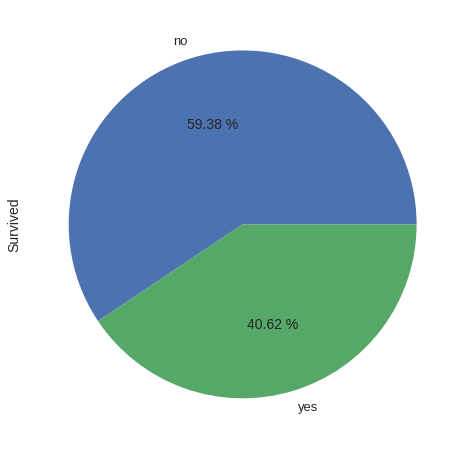

In [5]:
data.Survived.value_counts().plot.pie(autopct='%.2f %%')
plt.axes().set_aspect('equal')

__The task:__

Given a vector $X = (Name, Class, Age, Sex)$ can we find a function $f_{survival}(x) \in \{{yes, no}\}$ that accurately predicts the survival of the passengers in most cases?

How do we know if that function $f_{survival}(x)$  is any good?

To get some sense of the quality of this predictor we gather the following numbers.

* __True Positives__ $TP$, The number of correctly predicted events that belong to the 'positive' class
* __False Positives__ $FP$, The number of events falsely predicted as positive that actually belong to the 'negative' class
* __True Negatives__ $TN$, The number of correctly predicted events that belong to the 'negative' class
* __False Negatives__ $FN$, The number of events falsely predicted as negative that actually belong to the 'positive' class


We can look at the fraction of correctly labeled observations in the data

$$
    accuracy(\mathbf{y}, \mathbf{\hat{y}}) = \frac{1}{N} \sum_{i = 1}^N \mathbb{1}(y_i = \hat{y}_i)
$$

or simply put 

$$
    accuracy(\mathbf{y}, \mathbf{\hat{y}}) =  \frac{TP + TN}{ TP + FP + FN + TN} = \frac{\text{correclty predicted}}{\text{total number of observations}}.
$$

In some cases, also **Precision** and **Recall** can be useful:

$$
    precision=\frac{TP}{TP+FP}
$$

$$
    recall=\frac{TP}{TP+FN}
$$

Now we try to find a function where the accuracy is higher than 0.5


__One possible solution__:

Let's presume rich people get to go into lifeboats.

```
def f_class(passenger):
    if passenger.Pclass == 1:
        return 'yes'
    else:
        return 'no'
```



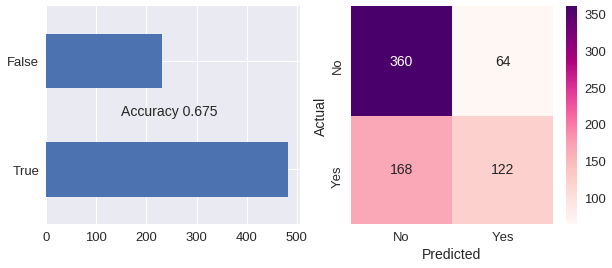

In [6]:
def f_class(passenger_class):
    return 'yes' if passenger_class == '1st' else 'no'

data = read_titanic()
prediction = data['Pclass'].apply(f_class)
truth = data['Survived']

plots.plot_bars_and_confusion(truth=truth, prediction=prediction)

What about the women? Maybe we get a better predictor.
 
```
def f_survival(passenger):
    if passenger.Sex == 'female':
        return 'yes'
    else:
        return 'no'
```

In [7]:
def f_sex(passenger_sex):
    return 'yes' if passenger_sex == 'female' else 'no'

data = read_titanic()
truth = data['Survived']
prediction = data['Sex'].apply(f_sex)

In [37]:
truth = truth.cat.reorder_categories(['yes', 'no'])
prediction = prediction.cat.reorder_categories(['yes', 'no'])

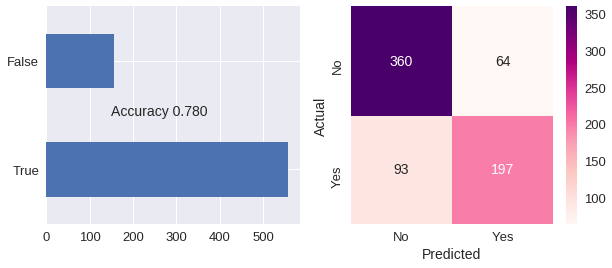

In [38]:
plots.plot_bars_and_confusion(truth=truth, prediction=prediction)

Maybe we can do better by using some combination of variables for our prediction. But how do you find a good combination of variables?

We could use visualizations to see correlations or obvious structures in the data. 

We could also try yo learn more about what happened on the Titanic. 

Perhaps even by watching that movie where Leonardo Di Caprio drowns in the end. 

![Movie Snaphsot](./ml/images/titanic-movie.jpg)

## Linear Models

Can we improve our predictor by combining more variables into one predictor?

Lets presume a linear weighted combination of variables:

$$
f(X)= \hat{\beta}_0 + \sum_{j=1}^p X_j \hat{\beta}_j
$$

or in our case when combining sex and money:

$$
f(X)= \hat{\beta}_0 + X_{Class} \hat{\beta}_{Class} + X_{Sex} \hat{\beta}_{Sex}  
$$

How do you find those weights?

Choose and then optimize a loss function. In this case the popular residual sum of squares 

$$L(\beta) = RSS(\mathbf{\beta}) = \sum_{i=1}^N (Y_i - X_i^T \beta)^2 $$

Rewrite the problem in matrix form:

\begin{align}
X^T &= (1, Class, Sex) \\ 
\mathbf{\hat{\beta}}^T &= (\hat{\beta}_0, \hat{\beta}_{Class}, \hat{\beta}_{Sex}) \\
\mathbf{y} &= {Y_1, \ldots, Y_N} 
\end{align}

Makes the formulation more compact for the predictor

$$
\hat{\mathbf{y}} = X^T \hat{\beta}
$$

and the loss function

$$
RSS(\beta) = (\mathbf{y} - \mathbf{X} \beta)^T (\mathbf{y} - \mathbf{X} \beta )
$$

Now we optimize the loss function just like we would any other function, by setting the derivative equals to zero.

$$
{RSS}^\prime(\beta) =  \mathbf{X}^T (\mathbf{y} - \mathbf{X} \beta ) \stackrel{!}{=} 0
$$

Solving for $\beta$ leads to

$$
\hat{\beta} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}
$$


We just performed  __Linear Least Squares__ regression.

Now we can define a function to predict passenger survival according to

$$
\hat{Y} = \begin{cases}
\text{Yes}, & \text{if $ f(X) \gt 0.5$} \\
\text{No}, & \text{if $ f(X) \le 0.5$}
\end{cases}
$$ 



We just *learned* the parameters for a statistical model based on labeled data.

Can a linear classification improve the classification of the Titanic dataset case?

We have to evaluate our 'learned' model independent test set

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

intercept = 1.249614025163504
coefs = [ -5.32189245e-01  -1.93620166e-01  -7.66326570e-05  -3.28654677e-03]


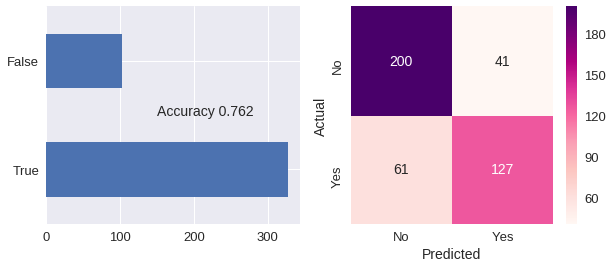

In [94]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

X = data[['Sex_Code', 'Pclass_Code', 'Fare', 'Age']]
y = data['Survived_Code']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6)

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

print('''intercept = {}
coefs = {}'''.format(reg.intercept_, reg.coef_))

y_prediction = reg.predict(X_test)
y_prediction = np.where(y_prediction > 0.5, 1, 0)

plots.plot_bars_and_confusion(truth=y_test, prediction=y_prediction)

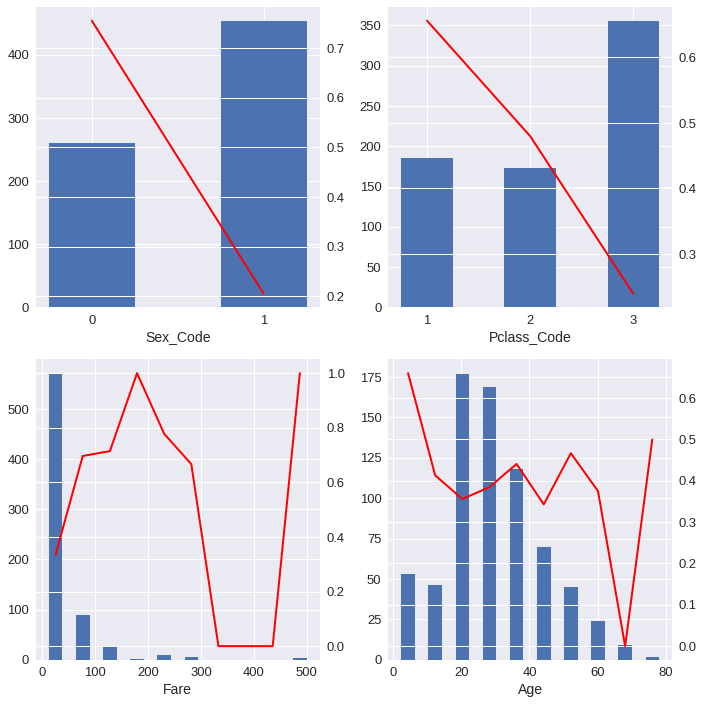

In [92]:
from importlib import reload
reload(plots)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10., 10.))
plots.plot_bins_perc(data, 'Sex_Code', 'Survived_Code', var_type='discrete', ax=ax1)
plots.plot_bins_perc(data, 'Pclass_Code', 'Survived_Code', var_type='discrete', ax=ax2)
plots.plot_bins_perc(data, 'Fare', 'Survived_Code', var_type='continuous', ax=ax3)
plots.plot_bins_perc(data, 'Age', 'Survived_Code', var_type='continuous', ax=ax4)
plt.tight_layout()

## Feature scaling

**Definition** Standardize the range of values that the features can take.

**Motivation** Having variables with very different value ranges may cause the algorithm to give wrong results. Specially those relying on Euclidian distance (e.g. kNN). Also results can be less explanatory at first sight.

**Types**
* Standardization
$$ 
x' = \frac{x - \bar{x}}{\sigma}
$$

* Rescaling
$$
x' = \frac{x - min(x)}{max(x) - min(x)}
$$

The model does not seem to improve the classification to a large degree. 

We will talk more about properly validating models later. 


For now lets look at the data in three dimensions.

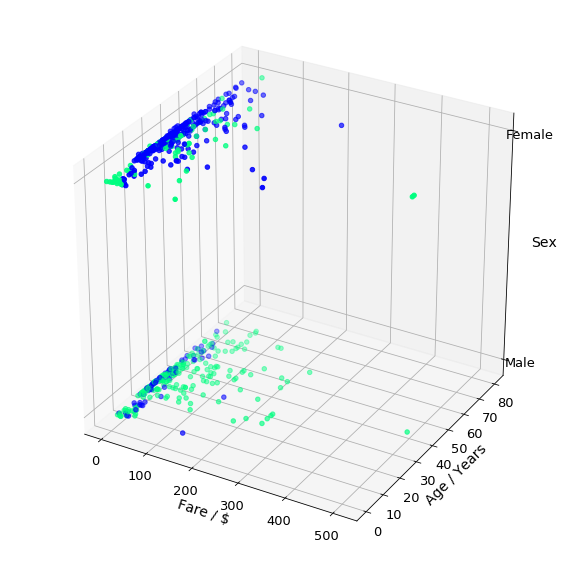

In [7]:
from mpl_toolkits.mplot3d import Axes3D
set_mpl()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data.Fare, data.Age, data.Sex_Code, c=data.Survived_Code, cmap='winter')
ax.set_xlabel('Fare / $')
ax.set_ylabel('Age / Years')
ax.set_zlabel('Sex')
ax.set_zticks([0,1])
ax.set_zticklabels(['Male', 'Female'])

In [8]:
set_sns()


## Support Vector Machines (SVMs)

The basic assumption underlying the least squares approach is that the model is linear in the observed variables. 
This works for data which can be separated by a linear function (a hyperplane in the parameter space).

But how do we know that this method finds the 'best' hyperplane for separating the two classes?

And what if the data cannot be seperated by a plane?


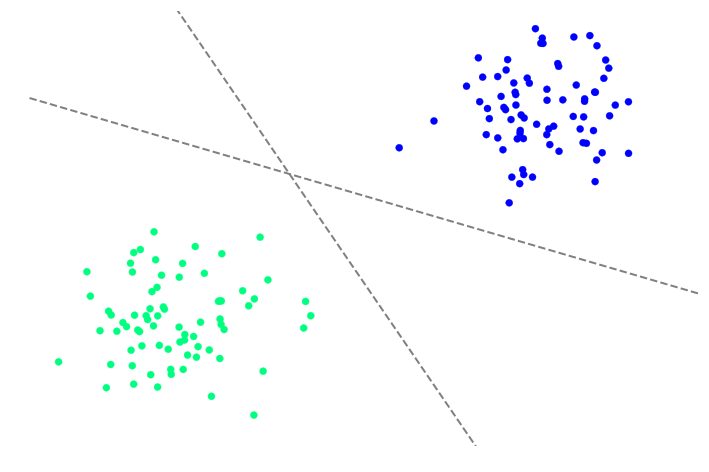

In [9]:
# many possible lines to separate the data. Which one is 'better'?
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=150, centers=2,
                  random_state=3, cluster_std=0.70)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')

xs = np.linspace(-6.5, 3, 2)
plt.plot(xs, -2 * xs - 2, color='gray', linestyle='--')
plt.plot(xs, -0.4 * xs + 2, color='gray', linestyle='--')
plt.xlim([-6, 3])
plt.ylim([-2, 6])
plt.axis('off')
None

#### The Support Vector Machine

Again we minimze a loss function.

$$
L(\beta) = C \max(0, 1 - y_i \beta^T x_i) + \frac{\lambda}{2}||{\beta}||^2
$$

Support Vector Machines try to find the hyperplane which maximimizes the margin to the points in different classes in the parameter space.

$C$ and $\lambda$ are two parameters which can be chosen beforehand. 

<p style="color:gray"> Note that, to fit the definition above, the label encoding has to be $y_i \in {-1, 1}$</p>

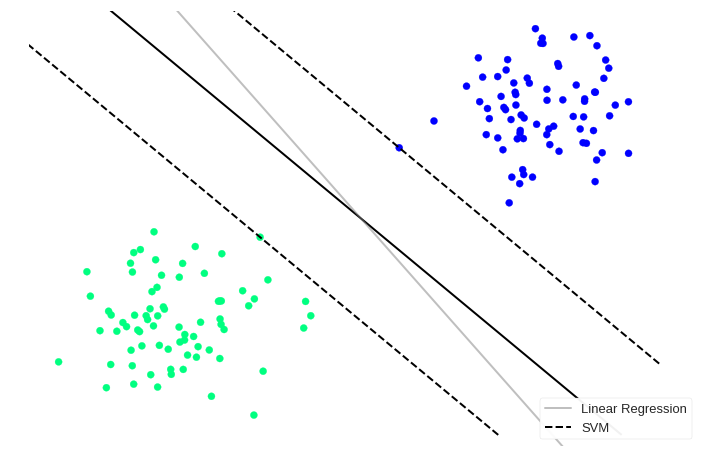

In [97]:
from sklearn.svm import SVC
from sklearn.datasets.samples_generator import make_blobs

X, y = make_blobs(n_samples=150, centers=2,
                  random_state=3, cluster_std=0.70)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')

clf = SVC(kernel='linear')
clf.fit(X, y)

plots.draw_svm_decission_function(clf, colors='black', label='SVM')

reg = linear_model.LinearRegression()
reg.fit(X, y)

plots.draw_linear_regression_function(reg, label='Linear Regression', color='gray', alpha=0.5)

plt.xlim([-6, 3])
plt.ylim([-2, 6])
plt.legend(loc='lower right', frameon=True, framealpha=0.95, facecolor='white')
None

So far the data has still been separable by a linear function. 

For many problems in real life however this isn't the case. 

Heres an example of (artificial) data which cannot be seperated by a line.

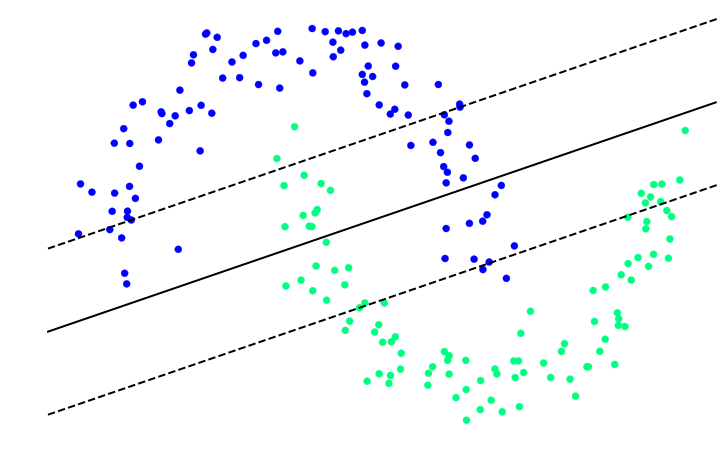

In [98]:
from sklearn.datasets.samples_generator import make_moons

X, y = make_moons(n_samples=200, noise=0.10)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')

clf = SVC(kernel='linear')
clf.fit(X, y)
plots.draw_svm_decission_function(clf, colors='black')


Now what if we take that data and transform it into a new variable. 

Find a function $h$ to create a new variable $X_h = h(X_1, X_2, \ldots)$.

In the case above some radial symmetry seems be an underlying feature of the data. 

We can exploit that

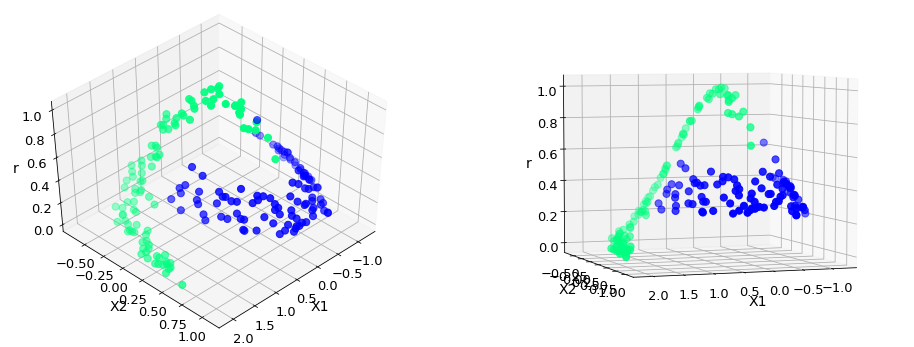

In [99]:
from mpl_toolkits import mplot3d
set_mpl()

# add a dimension by applying a transformation on the two variables in the data. 
r = np.exp(-(X[:, 0] ** 2 + X[:, 1] ** 2))

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='winter')
ax.view_init(elev=45, azim=45)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('r')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='winter')
ax.view_init(elev=5, azim=70)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('r')


In [13]:
set_sns()

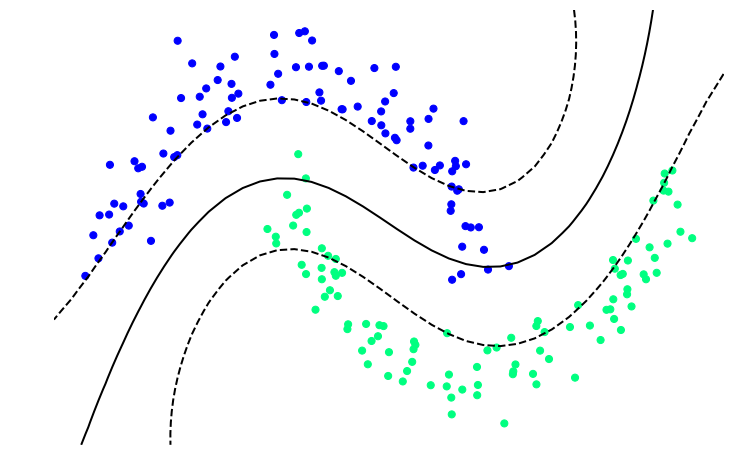

In [100]:
X, y = make_moons(n_samples=200, noise=0.10)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')

clf = SVC(kernel='rbf') #use the radial basis function instead of the linear one.
clf.fit(X, y)
plots.draw_svm_decission_function(clf, colors='black', label='SVM')

The same approach works for other linear methods as well. 

What makes SVM's so special?:

+ SVM's have proven to perform very well for many use-cases.

+ SVM's handle large number of dimensions relativly fast.

+ The kernel functions basically come for free.

+ Easily extendable to multi-class problems.


Kernel functions are constrained to fulfill certain criteria. *(See Chapter 12.3.1 in the Hastie Book)*

## Local Optimization and Decission Trees

So far we looked at loss functions which optimized some global optimization criterion.

In cases of non-linearity some a priori knowledge is necessary to transform the data to make it seperable by a hyperplane. (or you can use *Deep Learning*)


Idea:
* Split the parameter space into many subspaces where observations of the same class live.

Problem:
* Finding the *best* set of subspaces in the parameter space is an NP-complete problem (Its hard to solve. Really hard.)

One can however try approximate the solution using binary recursive splits in the parameter space.

In [87]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons
np.random.seed(1234)

X, y = make_moons(n_samples=200, noise=0.10)

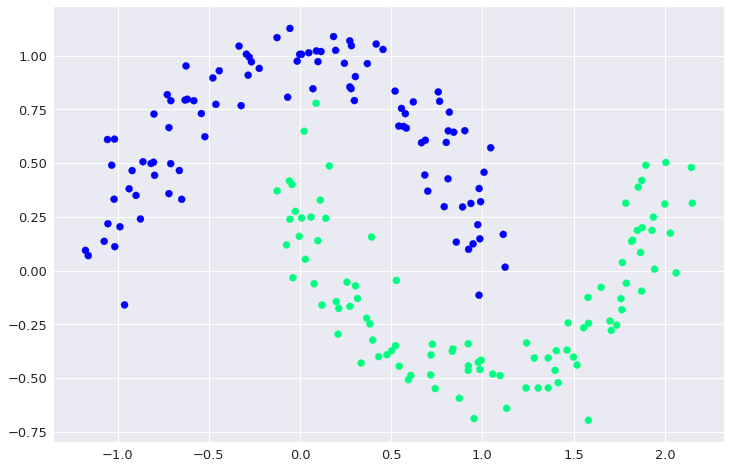

In [88]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')

In [89]:
clf = DecisionTreeClassifier(max_depth=5, criterion='entropy')
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

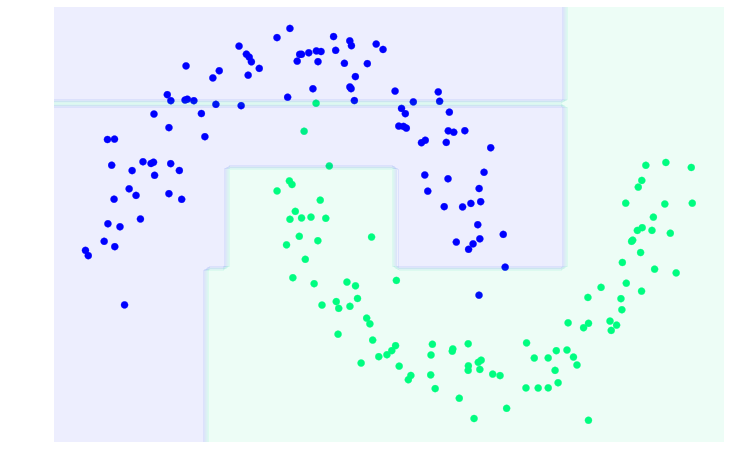

In [90]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
plots.draw_decission_boundaries(clf)

Outline for a tree building algorithm.

        def build_tree(space)
            if stopping_criterion_fulfilled():
                return {}
             
            variable, split_point = find_best_split(space)
                        
            left, right = split_space(space, variable, split_point)

            left_tree = build_tree(left)
            right_tree = build_tree(right)
               
            return {'node' : (variable, split_point), 'left': left_tree, 'right': right_tree}
            

For classification the best split in a node $m$ of the tree is found by minimizing an impurity measure $Q_m$.

Popular ones include Information Gain, Cross-Entropy or the Gini index. 

They all work by looking at one variable at a time and then iterating over all the possible splits to find the minimal $Q_m$

Implementations across languages/libraries are similar but differ in their choice of $Q_m$ and handling of continous variables.

### Apply Decision Trees to the Titanic example

Use scikit-learn to find the best possible decission tree for the Titanic dataset.

We will set different maximum depths.

What's happening?

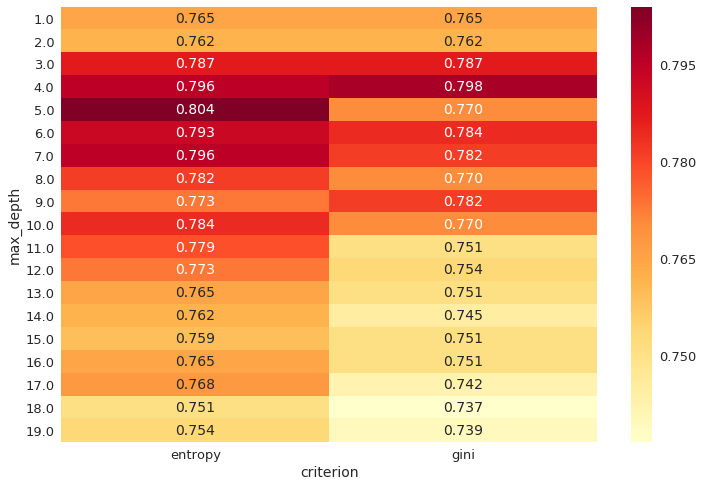

In [82]:
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import pandas as pd
import numpy as np
np.random.seed(1235)

data = read_titanic()

X = data[['Sex_Code', 'Pclass_Code', 'Fare', 'Age']]
y = data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

df = pd.DataFrame()
ps = ParameterGrid({'max_depth':range(1, 20), 'criterion':['entropy', 'gini']})
for d in ps:
    clf = DecisionTreeClassifier(max_depth=d['max_depth'], criterion=d['criterion'])
    clf.fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))
    df = df.append({'max_depth': d['max_depth'], 'criterion': d['criterion'], 'accuracy': acc}, ignore_index=True)

df = df.pivot('max_depth', 'criterion', 'accuracy')
sns.heatmap(df, cmap='YlOrRd', annot=True, fmt='.3f')
None


### Overfitting (Bias-Variance Tradeoff)

Assume the target $y$ is generated by some function $f(x)$ with added gaussian noise $\epsilon$

$$
y = f(x) + \epsilon, \qquad \epsilon \propto \mathcal{N}(\mu=0, \sigma)
$$

The mean squared error ($mse$) of the predictor function $\hat{f}(x) = \hat{y}$ is

$$
mse(y, \hat{f}) = (y - \hat{f}(x))^2
$$

Calculate the expectation value $mse$ 

$$
E[mse(y, \hat{f}) ] = E[(y - \hat{f}(x))^2]
$$

Some mathematical definitions up front.

__Variance__ of a random variable $X$ 
  
  $$
  Var(X) = E[(X - E[X])^2] = E[X^2] - E[X]^2 \iff     E[X^2] = Var[X] +  E[X]^2 
  $$
  
__Bias__ of an estimator $\hat{f}$

  $$
  Bias(\hat{f}) = E[\hat{f} - f] = E[\hat{f}] - E[f] = E[\hat{f}] - f
  $$

Since $f$ is a fixed function

$$
E[f] = f
$$

Using these definition on $y$ gives

\begin{align}
Var[y] = Var[ f(x) + \epsilon]  & = Var[f(x)] + Var[\epsilon] \\
                                & = Var[f(x)] + \sigma^2 \\
                                & = E[f(x)^2] - E[f(x)]^2 + \sigma^2 \\
                                & = f(x)^2 - f(x)^2 + \sigma^2 \\
                                & = \sigma^2 
\end{align}

Finally calculating $E[mse(y, \hat{f})]$ yields

\begin{align}
 E[(y - \hat{f}(x))^2]  & = E[y^2 + \hat{f}^2 - 2y\hat{f}] \\
                        & \ldots \\
                        & = \sigma^2 + Var[\hat{f}] + Bias[\hat{f}]^2.
\end{align}

This so called Bias-Variance dillemma is a universal problem in supervised machine learning. 

There are two error sources:

* High bias might decrease overall predictor performance.
* High variance can make the learned parameters prone to noise in the training data.  

If the parameters are tuned to the noise in the training data, the model will not generalize to new data. 

This problem is called __overfitting__

## Ensemble Methods

We have used a decission tree to classifiy artificial data as well as the Titanic data. 

Theoretically a decission tree is not limited in its depth. 

This quickly leads to overfitted tree models.


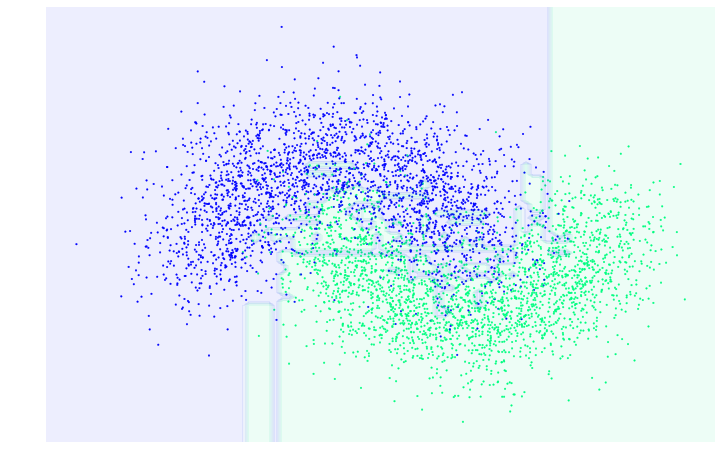

In [91]:
np.random.seed(1)
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=5000, noise=0.30)
clf = DecisionTreeClassifier(max_depth=300, criterion='entropy')
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=3, cmap='winter')
plots.draw_decission_boundaries(clf)

As mentioned in the discussion about decission trees earlier, the tree building algorithms try to find the optimal split criterion in some local region of the parameter space.

Finding the best overal split in parameter space is computationaly infeasible.

This means the decission tree algorithm can run into a local optimum. 

The idea of _ensemble learning_ is to train several weak (high bias, low variance) base classifiers on different subsets of the data and then combine them into one big classifier.

#### Bagging

A popular way to build ensembles is called *bagging*.

Split the training data into $B$ subsets using sampling with replacement (Bootstrapping). For each subset $b$ we train a classifier $\hat{f}_b$. Bagging then combines the overall prediction by taking the average.  

$$
\hat{y} = \hat{f}_{\text{bag}}(x) = \frac{1}{B} \sum_{b=1}^B \hat{f}_b (x) 
$$

#### Random Forests

Random Forests are a modification to bagging in which a number of *randomized decission trees* are trained. These randomized decission trees use a random subset of variables to find the best split in each node.

        def build_random_tree(space)
            if stopping_criterion_fulfilled():
                return {}
            
            random_variable_choice = choose_random_selection_of_variables()
            variable, split_point = find_best_split(space, random_variable_choice)
                        
            left, right = split_space(space, variable, split_point)

            left_tree = build_tree(left)
            right_tree = build_tree(right)
               
            return {'node' : (variable, split_point), 'left': left_tree, 'right': right_tree}

Random Forests are a very popular choice for classification tasks since their parameters can be easily tuned and they often outperform other methods.

In [100]:
np.random.seed(2)
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

data = read_titanic()

X = data[['Sex_Code', 'Pclass_Code', 'Fare', 'Age']]
y = data['Survived_Code']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

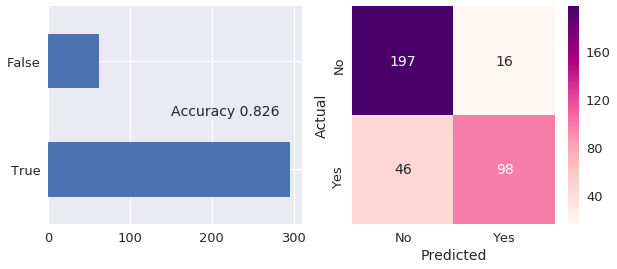

In [112]:
rf = RandomForestClassifier(n_estimators=20, max_depth=5)
rf.fit(X_train, y_train)

plots.plot_bars_and_confusion(truth=y_test, prediction=rf.predict(X_test))

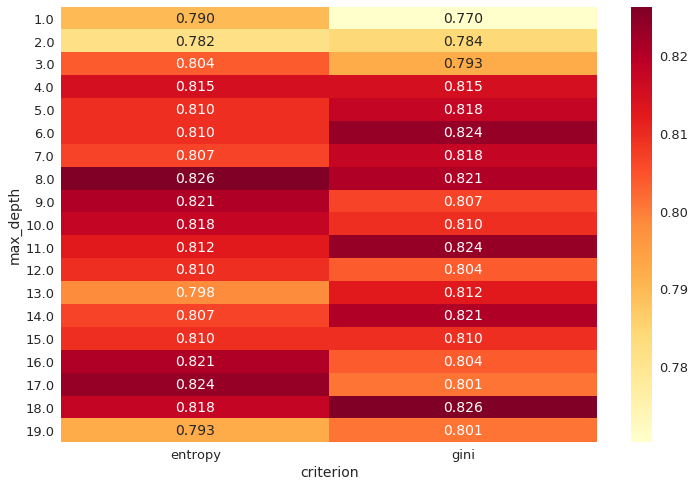

In [113]:
df = pd.DataFrame()
ps = ParameterGrid({'max_depth':range(1, 20), 'criterion':['entropy', 'gini']})
for d in ps:
    rf = RandomForestClassifier(max_depth=d['max_depth'], criterion=d['criterion'])
    rf.fit(X_train, y_train)
    acc = accuracy_score(y_test, rf.predict(X_test))
    df = df.append({'max_depth': d['max_depth'], 'criterion': d['criterion'], 'accuracy': acc}, ignore_index=True)

df = df.pivot('max_depth', 'criterion', 'accuracy')
sns.heatmap(df, cmap='YlOrRd', annot=True, fmt='.3f')

# Machine Learning (Unsupervised)

## Mathematical Notation and Problem Description

So far we have been occupied with 
predicting the values of one or more outputs or response variables $Y = (Y_1, \ldots, Y_m)$ for a given set of input or predictor variables $X = (X_1, \ldots , X_p)$. 

We have defined the loss functions $L(y, \hat y)$ to characterise how well we 'learned' some model $\hat f(x)$.

In unsupervised learning we have no given $Y$.
These methods try to find the underlying (joint) probability density $Pr(X)$ so that we might learn some properties about it.

One common question is whether $X$ is created by a mixture of two or more underlying random variables.

One can visualize this problem by looking at the following plot.

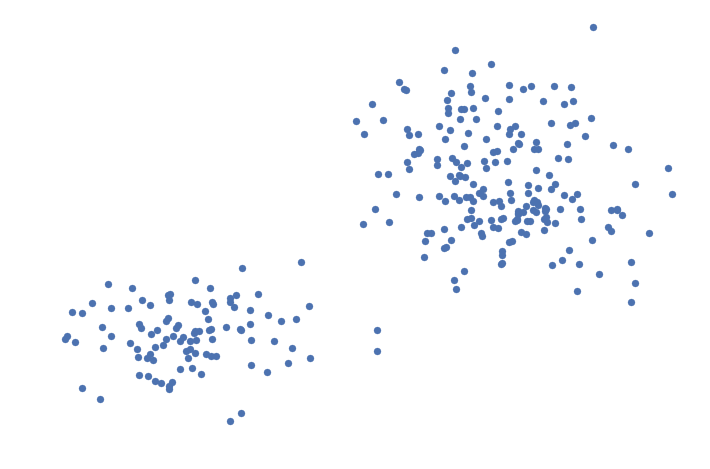

In [120]:
np.random.seed(1234)
from sklearn.datasets import make_blobs

# random number between 1 and 3
k = np.random.randint(1, 4)
X, y = make_blobs(n_samples=300, centers=k, center_box=(-2, 2), cluster_std=0.5)

plt.scatter(X[:, 0], X[:, 1])
plt.axis('off')
None

Can one infer $Pr(X)$ by looking at $X$, i.e. the blue dots?

In this case we know that this distribution of blue dots, $X$, was created by joining $k$ two dimensional gaussians with known standard deviation.
This is just what 

    X, y = make_blobs(n_samples=300, centers=k, center_box=(-2, 2), cluster_std=0.5)
 
does.
We even know in what region of space we have to look for the centroids of these blobs. 

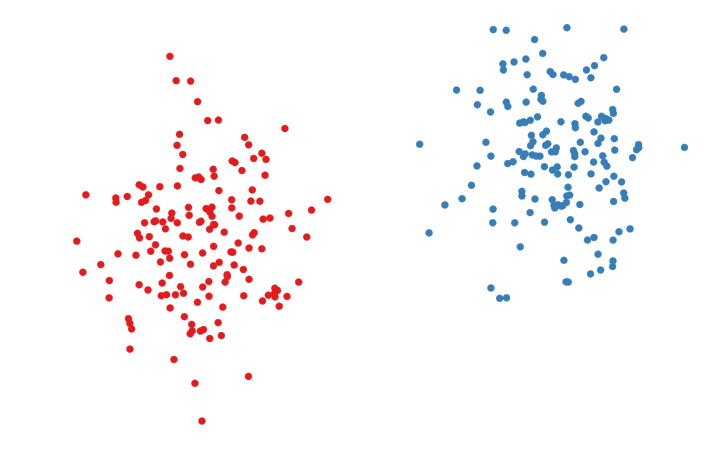

In [118]:
import matplotlib
cmap = matplotlib.cm.get_cmap('Set1')
plt.scatter(X[:, 0], X[:, 1], c=cmap(y))
plt.axis('off')
None

## Clustering Algorithms

Clustering algorithms try to find modes of $Pr(X)$ based on densities, neighbourhood relations or any other measure of 'similarity'  between points.

More generally speaking to quote wikipedia again:

>Cluster analysis or clustering is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense or another) to each other than to those in other groups (clusters).


### K-Means Algorithm

The k-Means algorithm (or Loyds algorithm) tries to find a partition of the data into $k$ clusters $S = \{S_1, \ldots, S_k\}$  which minimize the variance within those clusters. The number of clusters $k$ has to specified by the user.

Formally speaking the algorithm solves
$$
{\underset {S}{\operatorname {arg\,min} }}\sum _{S_i \in S}\sum _{x \in S_{i}}\left\|x -{\overline{x}}_{S_i}\right\|^{2}.
$$

It does so iterativly according to the following steps 

1. Pick some initial cluster means (or centroids) $\{m_1, \ldots, m_k \}$ either randomly or according to some heuristic.

2. Create a partition $S$  by assigning each point $x \in X$ to the cluster $S_i$ where the distance to $m_i$ is the smallest.

3. Update the cluster means by calculating the means within the assigned clusters. 

4. Repeat steps 2 and 3 until convergence.


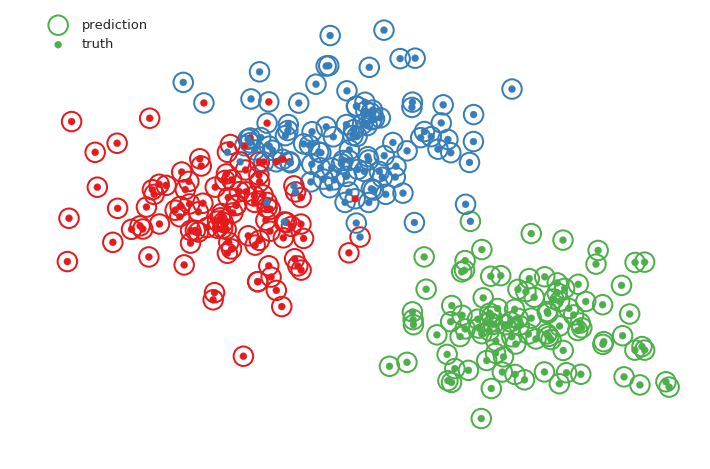

In [122]:
np.random.seed(1234)
from sklearn.cluster import KMeans

X, y = make_blobs(n_samples=300, centers=k, center_box=(-2, 2), cluster_std=0.5)

prediction = KMeans(n_clusters=3).fit_predict(X)

# shift the colors
prediction = (prediction + 2 ) % 3

plt.scatter(X[:, 0], X[:, 1], facecolor='', edgecolors=cmap(prediction), lw=2,  s=380, label='prediction')
plt.scatter(X[:, 0], X[:, 1], c=cmap(y), label='truth')
plt.legend(loc='upper left')
plt.axis('off')
None

The k-Means algorithm works well on convex clusters with similar standard deviations. But it fails on elongated or concave shapes.


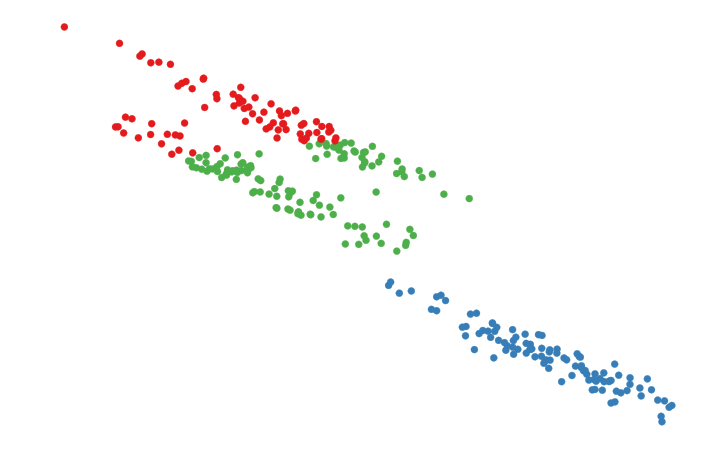

In [123]:
np.random.seed(170)
X, y = make_blobs(n_samples=300, centers=3,)
transformation = [[0.4, -0.8], [-0.4, 0.4]]
X_elongated = np.dot(X, transformation)
prediction = KMeans(n_clusters=3,).fit_predict(X_elongated)


plt.scatter(X_elongated[:, 0], X_elongated[:, 1], c=cmap(prediction))
plt.axis('off')
None

### Gaussian Mixture Models

The k-Means algorithm is a special case of the __expectation-maximization__ for solving __Gaussian mixture models__.

Gaussian mixtures assume that $Pr(X)$ is a mixture of gaussians. Explicetly it assumes 

$$
X = (1 - U) \cdot X_1 + U \cdot X_2 
$$

where $U \in \{0, 1\}$ with a fixed (unkown) probability for either 1 or 0 and $X_1$ and $X_2$ both normally distributed with unkown parameters. 

The EM-Algorithm tries to find these unkown parameters by approximating a lieklihood and minimizing it.

For more details see chapter 8.5 in the book and here

https://en.wikipedia.org/wiki/Expectation–maximization_algorithm


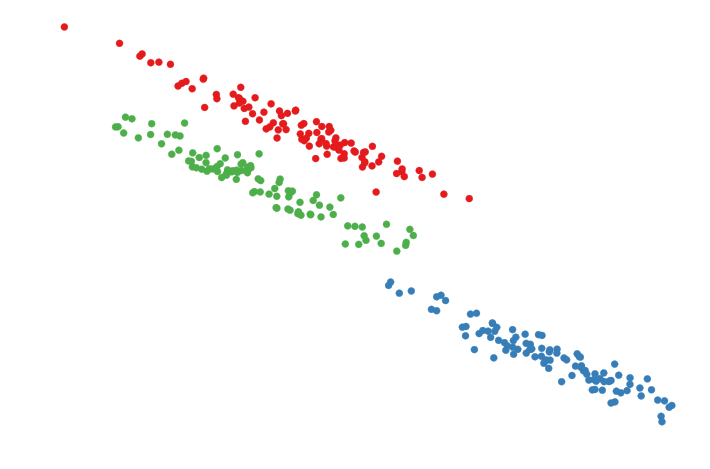

In [124]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=3).fit(X_elongated)
prediction = gm.predict(X_elongated)
plt.scatter(X_elongated[:, 0], X_elongated[:, 1], c=cmap(prediction))
plt.axis('off')
None

## Yeehaw!!!

If you reached this point and you are still alive (and awake) I'd like to congratulate you.

In [125]:
df = df.pivot('max_depth', 'criterion', 'accuracy')
sns.heatmap(df, cmap='YlOrRd', annot=True, fmt='.3f')

score = cross_validate(tree, X, y, scoring=make_scorer(roc_auc_score), cv=5)
print('ROC AUC Decission Tree {:0.3f} +/- {:0.3f}'.format(score['test_score'].mean(), score['test_score'].std()))

score = cross_validate(rf, X, y, scoring=make_scorer(roc_auc_score), cv=5)
print('ROC AUC Random Forest {:0.3f} +/- {:0.3f}'.format(score['test_score'].mean(), score['test_score'].std()))

plots.draw_decission_boundaries(gm)

KeyError: 'max_depth'

## Classifier Validation 

### k - Nearest Neighbour Methods

The k-NN classifier is  a good example of a model that can be easily overfitted. 

Lets assume that the decission function is constant over some local region in the parameter space:

$$
\hat{f}(x_0) = \hat{y} = \frac{1}{k} \sum_{x_i \in N_k(x_o)} y_i
$$

where $x_i \in N_k(x)$ describes the $k$ points in the training data $\mathbf{X}$ that are in the *neighbourhood* of $x_0$.

To put it in words. We assume $x$ will have the same $y$ as other points nearby.

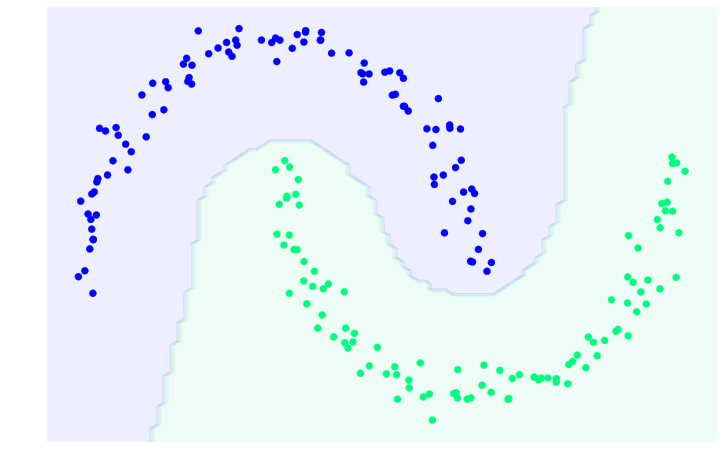

In [24]:
from sklearn.datasets.samples_generator import make_moons
from sklearn.neighbors import KNeighborsClassifier

X, y = make_moons(n_samples=200, noise=0.05)


knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
plots.draw_decission_boundaries(knn)

This works pretty well in this artifical, low-noise, example. 

Classification on noisy data will not work as good.

Real world data always has some form of noise.

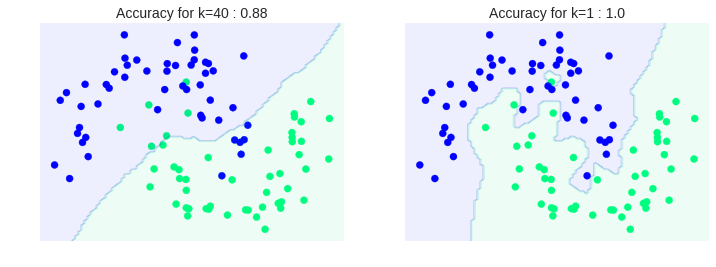

In [20]:
np.random.seed(1234)
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

X, y = make_moons(n_samples=100, noise=0.2)

knn = KNeighborsClassifier(n_neighbors=40)
knn.fit(X, y)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
plots.draw_decission_boundaries(knn, ax=ax1)
ax1.set_title('Accuracy for k=40 : {}'.format(accuracy_score(y, knn.predict(X))))
ax1.axis('off')

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)

ax2.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter')
plots.draw_decission_boundaries(knn, ax=ax2)
ax2.set_title('Accuracy for k=1 : {}'.format(accuracy_score(y, knn.predict(X))))
ax2.axis('off')
None

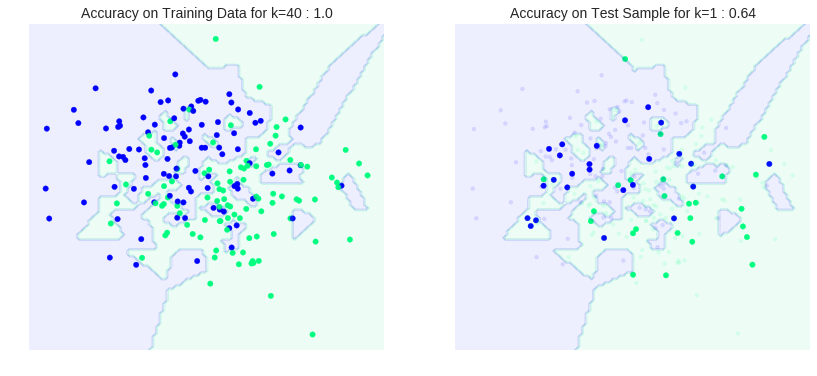

In [21]:
np.random.seed(1234)

X, y = make_moons(n_samples=200, noise=0.7)
X_test, y_test = make_moons(n_samples=50, noise=0.7)


knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='winter')
plots.draw_decission_boundaries(knn, ax=ax1)
ax1.set_title('Accuracy on Training Data for k=40 : {}'.format(accuracy_score(y, knn.predict(X))))
ax1.axis('off')

ax2.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=30, cmap='winter')
ax2.scatter(X[:, 0], X[:, 1], c=y, s=15, alpha=0.1,  cmap='winter')
plots.draw_decission_boundaries(knn, ax=ax2)
ax2.set_title('Accuracy on Test Sample for k=1 : {}'.format(accuracy_score(y_test, knn.predict(X_test))))
ax2.axis('off')
None

In [22]:
from sklearn.metrics import mean_squared_error

np.random.seed(1234)
X, y = make_moons(n_samples=400, noise=0.2)
X_test, y_test = make_moons(n_samples=400, noise=0.2)

e_train = []
e_test = []
for k in range(1, 200):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)
    e_train.append(mean_squared_error(y, knn.predict(X)))
    e_test.append(mean_squared_error(y_test, knn.predict(X_test)))

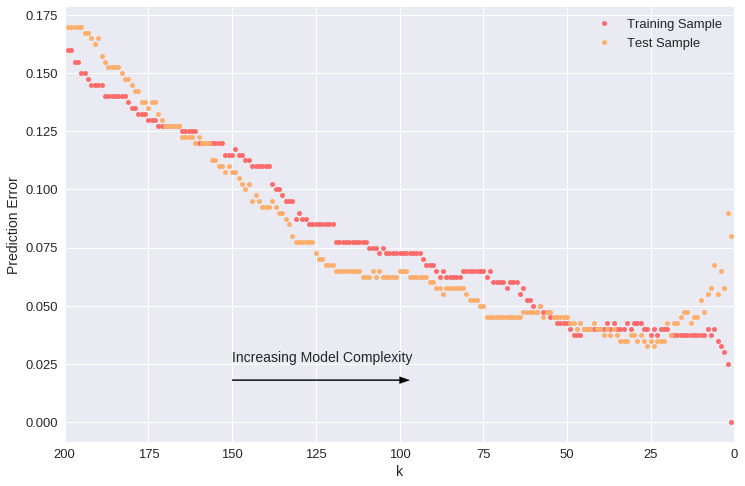

In [23]:
plt.plot(range(1, 200), e_train,'.', color='#FF6B6B', ms=10, label='Training Sample')
plt.plot(range(1, 200), e_test, '.' ,color='#FFAE6B', ms=10, label='Test Sample', )
plt.xlim(200, 0)
plt.xlabel('k')
plt.ylabel('Prediction Error')

plt.text(150, 0.026, 'Increasing Model Complexity')
plt.arrow(150, 0.018, -50, 0, width = 0.0005, head_width=0.003, head_length=3, fc='k', ec='k')
plt.legend()

### Validation on independent test sets

Validating the fitted models is essential for avoiding overfitting.

The predictions error has to be assesed on an independent test dataset. 

Models might still be susceptible to noise in the training data.

#### Cross Validation

A $k$-fold cross validation automatically splits the training data into $k$ subsets.

The model is then trained on $k-1$ subsets and evaluated on the remaining set. 

In [75]:
%%HTML
    <style>
    .training_set { fill: #FF6B6B;}
    .test_set { fill: #FFAE6B; }
    </style>
<h4> 5-Fold Cross Validation </h4>
<p> First Iteration: </p>
<p> </p>
<svg width="800" height="140">
<g transform="scale(0.9)">
  <rect x="0", y="0", width="150" height="80" class="training_set" />
  <rect x="160", y="0", width="150" height="80" class="training_set" />
  <rect x="320", y="0", width="150" height="80" class="training_set" />
  <rect x="480", y="0", width="150" height="80" class="training_set" />
  <rect x="640", y="0", width="150" height="80" class="test_set" />
    
  <rect x="0", y="90", width="630" height="3" class="training_set" />
  <rect x="640", y="90", width="150" height="3" class="test_set" />
    
  <text x="0" y="115" class="training_set">
    Training Data
  </text>
  <text x="640" y="115" class="test_set">
    Test Data
  </text>
</g>
</svg>

<p> Second Iteration: </p>
<p> </p>
<svg width="800" height="140">
<g transform="scale(0.9)">
  <rect x="0", y="0", width="150" height="80" class="training_set" />
  <rect x="160", y="0", width="150" height="80" class="training_set" />
  <rect x="320", y="0", width="150" height="80" class="training_set" />
  <rect x="480", y="0", width="150" height="80" class="test_set" />
  <rect x="640", y="0", width="150" height="80" class="training_set" />
    
  <rect x="0", y="90", width="470" height="3" class="training_set" />
  <rect x="480", y="90", width="150" height="3" class="test_set" />
  <rect x="640", y="90", width="150" height="3" class="training_set" />
    
  <text x="0" y="115" class="training_set">
    Training Data
  </text>
  <text x="480" y="115" class="test_set">
    Test Data
  </text>
</g>
</svg>

<p> Third Iteration: </p>
<p> </p>
<svg width="800" height="140">
<g transform="scale(0.9)">
  <rect x="0", y="0", width="150" height="80" class="training_set" />
  <rect x="160", y="0", width="150" height="80" class="training_set" />
  <rect x="320", y="0", width="150" height="80" class="test_set" />
  <rect x="480", y="0", width="150" height="80" class="training_set" />
  <rect x="640", y="0", width="150" height="80" class="training_set" />
    
  <rect x="0", y="90", width="310" height="3" class="training_set" />
  <rect x="320", y="90", width="150" height="3" class="test_set" />
  <rect x="480", y="90", width="310" height="3" class="training_set" />
    
  <text x="0" y="115" class="training_set">
    Training Data
  </text>
  <text x="320" y="115" class="test_set">
    Test Data
  </text>
</g>
</svg>
<p>...</p>
<p>...</p>

#### Other Quality Metrics

Accuracy is not always a good measure of model quality.

Imagine a classifier function which simply predicts a fixed outcome.

        def f_fixed(x):
            return 0
            
On an imbalanced dataset this classifier will have an accuracy equal to the ratio of positive examples to the total number of examples.

In [25]:
def f_fixed(x):
    return np.zeros(shape=len(x))

data = read_titanic()

X = data
y = data['Survived_Code']

print('Accuracy of fixed classifier {:1.6f} \n'.format(accuracy_score(y, f_fixed(X))))

print('Ratio of survived to total passengers: ')
print(data.Survived.value_counts(normalize=True))


Accuracy of fixed classifier 0.593838 

Ratio of survived to total passengers: 
no     0.593838
yes    0.406162
Name: Survived, dtype: float64


Another view at the confusion matrix. It generalizes to more than two classes as seen in the picture below.

![A confusion matrix](./ml/images/confusion_matrix.png)

The numbers in the confusion matrix can be used to calculate a whole range of qulity criteria.

Lets build a classifier which randomly chooses an outcome and look at the different criteria.

```
def f_random(passenger):
    return np.random.choice(['yes', 'no')
```


<a href="https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal" style="color:#BBBBBB;">The nice Stack Overflow post where I stole the picture from.</a>



In [27]:
def f_random(x):
    return np.random.randint(2, size=len(x))

prediction = f_random(X)
cm = confusion_matrix(y, prediction)

FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print(TPR, TNR, PPV, NPV, FPR, FNR, FDR, ACC)

[ 0.5259434   0.53448276] [ 0.53448276  0.5259434 ] [ 0.62290503  0.43539326] [ 0.43539326  0.62290503] [ 0.46551724  0.4740566 ] [ 0.4740566   0.46551724] [ 0.37709497  0.56460674] [ 0.52941176  0.52941176]


In [28]:
from sklearn.metrics import recall_score, precision_score
print(recall_score(y, prediction))
print(precision_score(y, prediction))

0.534482758621
0.435393258427


Precission and recall can be understood in an intuitive way

* __Recall__ How many of the wanted examples are found.
* __Precission__ The percentage of the found examples that are actually relevant.

So what should you optimze for? Maximumg accuracy or precission or recall?

There is no clear answer. It depends on your use-case. Can you tolerate false positives? 
Can you tolerate losing some true positives?

We will always have to make the trade-off between recall and precission. 
There are several metrics which try to combine both into one.

The $f_{\beta}$ score is one example.

$$
f_{\beta } = (1+\beta ^{2})\cdot {\frac {\mathrm {precision} \cdot \mathrm {recall} }{(\beta ^{2}\cdot \mathrm {precision} )+\mathrm {recall} }} =
\frac {(1 + \beta^2) \cdot TP }{(1 + \beta^2) \cdot TP + \beta^2 \cdot FN + FP}.
$$

But in the end there is no absolute truth to whats best.



#### Discussion

Imagine you devise a new, cheap and easy cancer test. 
What should you optimize your decission threshold for?
Precission or recall?

#### Excersise 4 (10-15 Minutes)

scikit-learn comes with several functions to make working with cross validations easy.

1. Read the Titanic dataset into a dataframe. 
2. Calculate cross validated accuracy, recall, precision and f1 score using `sklearn.model_selection.cross_validate` with a 5-fold CV for a k-NN, SVM and DecissionTree classifier.
3. Print or plot the mean and standard deviation of the accuracies for each classifier.

In [29]:
# %load ./ml/solutions/exercise_5.py

## Decission Thresholds and Classifier Validation

Classifier objects usually provide all of the following methods

* `classifier.fit(X)` takes training data and finds some parameters based on that data.
* `classifier.predict(X_new)` takes new data (one row or many) and predicts the target label for each row.
* `classifier.predict_proba(X_new)` takes new data (one row or many) and predicts 'some notion of confidence'.

In the case of binary classification (i.e. two classes) the `classifier.predict_proba` usually returns a number where higher numbers indicate some measure of 'confidence'.

The `classifier.predict(X_new)` is basically a a wrapper around the `predict_proba` function which simply applies a decission threshold at some value (usually 0.5).
This is exactly what we did in the case of linear least squares regression.


$$
\hat{Y} = \begin{cases}
\text{Yes}, & \text{if $ f(X) \gt 0.5$} \\
\text{No}, & \text{if $ f(X) \le 0.5$}
\end{cases}
$$

In this case the decission threshold corresponds to the distance of a point to the seperating hyperplane.


In [30]:
#verstecken
# %load ./ml/solutions/exercise_1.py

But what does this say about the actual probability of a new data point being of either class?

In the case above, data created by two gaussian distributions, the distance certainly maps to the underlying probability density in *some* way. But it is in no way an actual *significance* or *confidence*

The function `predict_proba` is a slight misnomer. While some classifiers return numbers between 0 and 1, by no means do all classifier return the desired probability estimate.

Still the number can be interpreted as some level of 'certainty' in many cases.

Varying the decission threshold is extremely usefull for modifying your classifier output to create more/less 'conservative' predictions.


In essence this is a new classifier/predictor with a free parameter. The old $\hat{y} = \hat{f}(x)$ now becomes

$$
\hat{y} = \hat{f}(x, \alpha)
$$

where $\alpha$ is a parameter which can be chosen freely (or optimized according to some criterion which has nothing to do with the underlying loss function of the predictor.)

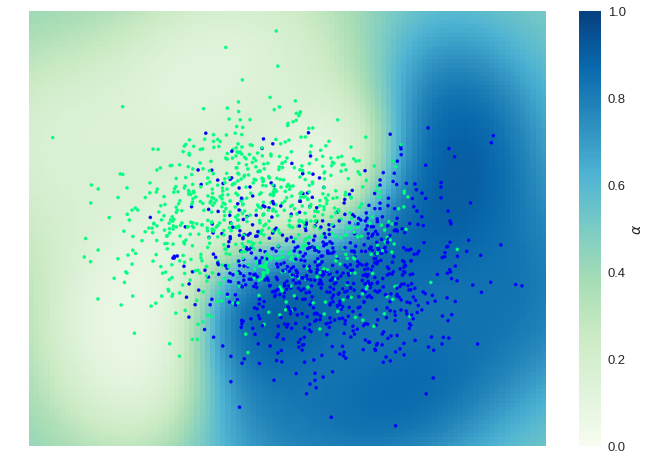

In [31]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1500, noise=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap='winter_r')

X_train, X_test, y_train, y_test = train_test_split(X, y)

clf = SVC(probability=True)
clf.fit(X_train, y_train)
predictions = clf.predict_proba(X_test)[:,1]

plots.draw_decission_surface(clf, predictions, label=r'$ \alpha $')

None

#### Classifier Calibration

There are ways to transform the output of a classifiers into more reasonable probability estimates. 

This process is often called classifier calibration. There is a detailed guide in sklearn's documentation

http://scikit-learn.org/stable/modules/calibration.html



#### Receiver Operating Characteristic 

The decission threshold is incredibly helpful in validating classifier performance.

The plot of false positive rate vs. true positive rate while varying the decission threshold is called the Receiver Operating Characteristic curve (ROC curve).

It is a very popular tool for classifier performance evaluation.

Wikipedia Quote:

> Following the attack on Pearl Harbor in 1941, the United States army began new research to increase the prediction of correctly detected Japanese aircraft from their radar signals. For this purposes they measured the ability of radar receiver operators to make these important distinctions, which was called the Receiver Operating Characteristics.


A classifier which assigns random labels to the data will have a ROC curve which lies on the diagonal. With an area under curve (AUC) of 0.5.


__Problems__

There are circumstance in which the ROC is not a good measure of quality. 

See https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve for a discussion.

Also in the case of imbalanced classes (eg. imagine you had 10000 surviors but 10 deceased passengers) the ROC curve itself won't change. The intepretation of the ROC curve however changes drastically.

In that case its better to plot the precission vs recall curve and the corresponding area under curve.

See https://classeval.wordpress.com for some very good discussions on classifier evaluation.

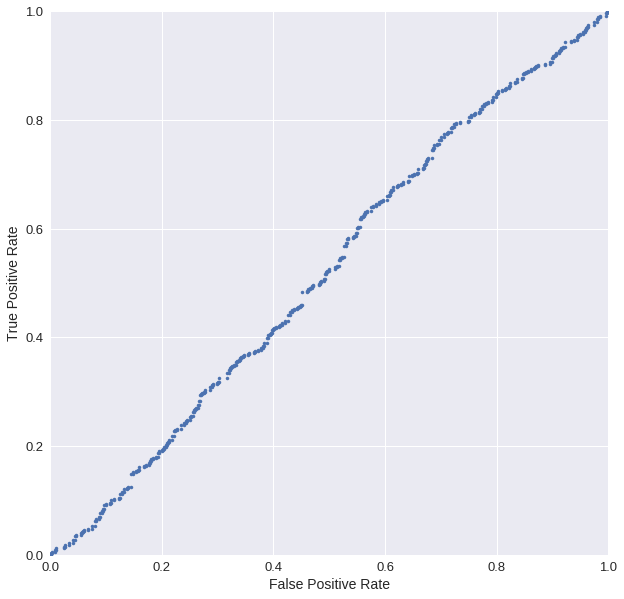

In [32]:
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve

X, y = make_classification(n_samples=1000)

prediction = np.random.uniform(size=len(y))

fpr, tpr, _ = roc_curve(y, prediction)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, '.')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


#### Excersise 5. Validation Curves (15 minutes)

1. Create some artificial noisy data.

        X, y = make_moons(n_samples=5000, noise=0.8)

2. Create a classifier
        
        # either
        clf = KNeighborsClassifier(n_neighbors=50)
        # or
        clf = DecisionTreeClassifier(min_samples_leaf=50))
        
3. Create an cross validation iterator
        
        cv = StratifiedKFold(n_splits=5)
        
4. Iterate over the splits in the cross validation

        for train, test in cv.split(X, y):
            X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]

5. Plot recall vs. precission and fpr vs tpr for each split in the cross validation

        # use these two functions
        from sklearn.metrics import precision_recall_curve, roc_curve
        
6. Calculate the mean and standard deviation of the area under both curves.

        

In [37]:
# %load ./ml/solutions/exercise_5.py
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

np.random.seed(1234)
data = read_titanic()

X = data[['Sex_Code', 'Pclass_Code', 'Fare', 'Age']]
y = data['Survived_Code']

svc = SVC(kernel='linear')
knn = KNeighborsClassifier(n_neighbors=5)
tree = DecisionTreeClassifier(max_depth=5)

results = []
for clf, name in zip([svc, knn, tree], ['SVM', 'kNN', 'tree']):
    r = cross_validate(clf, X=X, y=y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])
    df = pd.DataFrame().from_dict(r)
    df['classifier'] = name
    results.append(df)

df = pd.concat(results).drop(['fit_time', 'score_time'], axis='columns')

means = df.groupby('classifier').mean()
deviations = df.groupby('classifier').std()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
sns.heatmap(means, cmap='viridis', annot=True, ax=ax1, vmin=0, vmax=1)
sns.heatmap(deviations, cmap='viridis', annot=True, ax=ax2, vmin=0, vmax=1)


ImportError: cannot import name 'cross_validate'

## Regression

Regression and classification are very similar in nature. The biggest difference being that the target variable $y$ is continous and has a natural ordering associated with it. 

The same basic rules for classification apply for regression as well. 

* Models need to be verified on independent test data
* There is a tradeoff between bias and variance. Overfitting can occur.
* There are many quality measures to pick from. 


Lets try and use regression to predict housing prices.

In [40]:
from sklearn.datasets import load_boston
from IPython.display import Markdown, display
houses = load_boston()

display(Markdown(houses.DESCR))

Boston House Prices dataset
===========================

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's

    :Missing Attribute Values: None

    :Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset.
http://archive.ics.uci.edu/ml/datasets/Housing


This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.

The Boston house-price data has been used in many machine learning papers that address regression
problems.   
     
**References**

   - Belsley, Kuh & Welsch, 'Regression diagnostics: Identifying Influential Data and Sources of Collinearity', Wiley, 1980. 244-261.
   - Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.
   - many more! (see http://archive.ics.uci.edu/ml/datasets/Housing)


In [41]:
names = list(houses['feature_names']) +  ['price']
data = pd.DataFrame(data=np.c_[houses['data'], houses['target']], columns=names)
data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


Our regression task is to predict the price of a house from the 13 given variables. From a plot of some of the variables we can see some weak correlations in some variables.

None of these variables alone would suffice to build a good predictor. Hence we try to use multivariate regression methods.

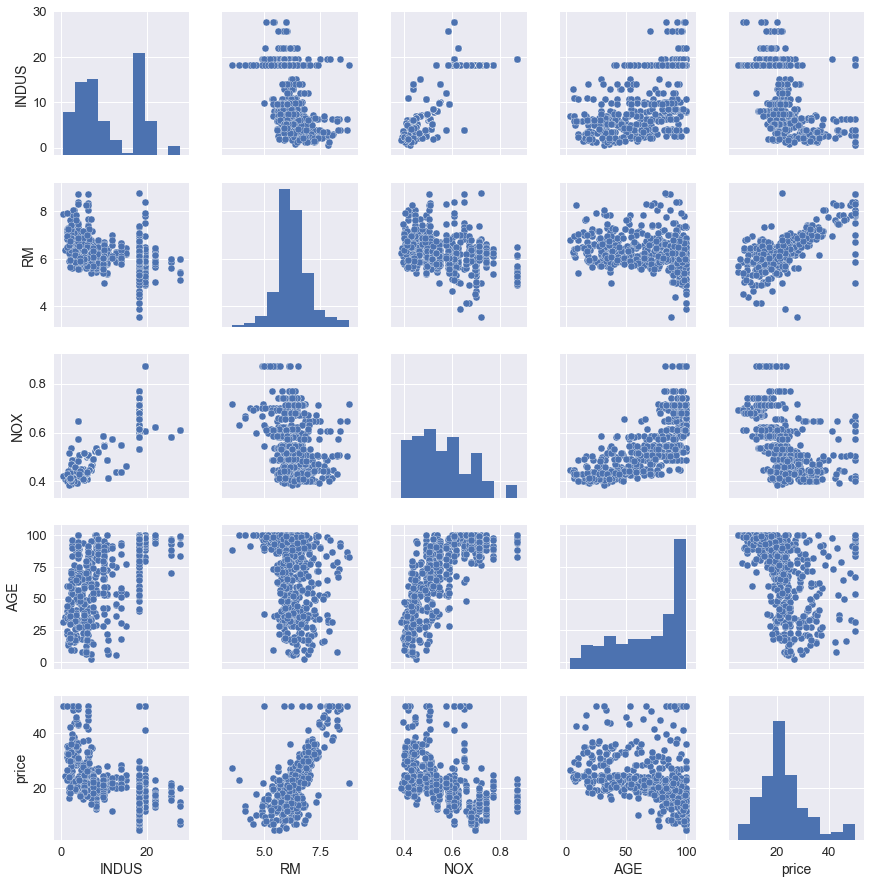

In [42]:
sns.pairplot(data[['INDUS', 'RM', 'NOX', 'AGE', 'price']])

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_validate

X, y = load_boston(return_X_y=True)

reg = LinearRegression()
score = cross_validate(reg, X, y, cv=5, scoring='neg_mean_absolute_error')
print('Score linear regression {:0.3f} +/- {:0.3f}'.format(score['test_score'].mean(), score['test_score'].std()))

reg = SVR(kernel='rbf')
score = cross_validate(reg, X, y, cv=5, scoring='neg_mean_absolute_error')
print('Score SVR {:0.3f} +/- {:0.3f}'.format(score['test_score'].mean(), score['test_score'].std()))

reg = DecisionTreeRegressor()
score = cross_validate(reg, X, y, cv=5, scoring='neg_mean_absolute_error')
print('Score Tree {:0.3f} +/- {:0.3f}'.format(score['test_score'].mean(), score['test_score'].std()))

reg = RandomForestRegressor()
score = cross_validate(reg, X, y, cv=5, scoring='neg_mean_absolute_error')
print('Score RandomForestRegressor {:0.3f} +/- {:0.3f}'.format(score['test_score'].mean(), score['test_score'].std()))

Score linear regression -4.257 +/- 0.981
Score SVR -6.921 +/- 1.762
Score Tree -3.945 +/- 0.549
Score RandomForestRegressor -3.149 +/- 0.706


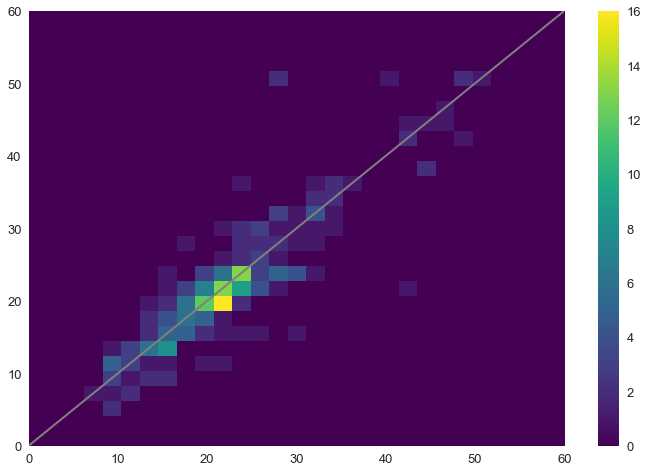

In [44]:
reg = RandomForestRegressor()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
reg.fit(X_train, y_train)
prediction = reg.predict(X_test)

bin_edges = np.linspace(0, 60, 30)
plt.hist2d(prediction, y_test, bins=bin_edges, cmap='viridis',)
plt.colorbar()
plt.grid()
plt.plot([0, 60], [0, 60], color='gray')
None

The output of the predictor shows stronger correlation than any of the other variables. It is still noisy and shows some smearing and outliers. The output of a regressor should never be understood as 'true' but rather as a new correlated variable which can show noise and bias. 

There is a fundemental difference between *curve fitting* and regression.

* __Curve Fitting__ All data is available. Some known (or presumed) analytical function is fit to the data to estimate free parameters of that function.


* __Regression__ Training data is available. A model is fitted on training data to predict the dependent variable on some new, unknown, data.

There is a lot more to learn about linar models and regression. Check sklearn's user guide on linear models for more information 
http://scikit-learn.org/stable/modules/linear_model.html

A very popular regression metric is the $R^2$ score. Read about it here

https://en.wikipedia.org/wiki/Coefficient_of_determination

and here

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html .

### Density based methods 

Clustering methods based on density take a more heuristic approach. Assuming that regions of higher density belong together while points in sparse regions are considered as noise.

#### DBSCAN 

Density-based spatial clustering of applications with noise (DBSCAN) is the most popular density based clustering algorithm. It can also find points in non-convex clusters.

Read more here:
    https://en.wikipedia.org/wiki/DBSCAN
    

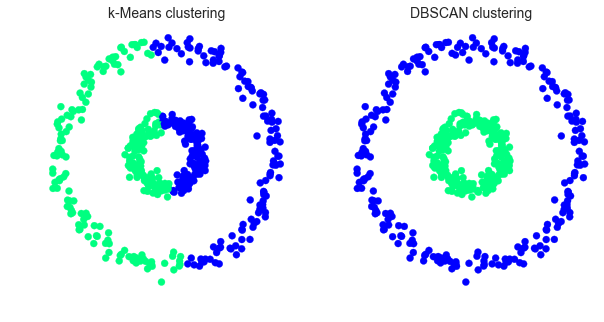

In [50]:
np.random.seed(1234)
from sklearn.datasets import make_circles
from sklearn.cluster import DBSCAN, KMeans

X, y = make_circles(n_samples=500, noise=0.05, factor=0.3)

prediction_kmeans = KMeans(n_clusters=2).fit_predict(X)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title('k-Means clustering')
ax1.scatter(X[:, 0], X[:, 1], c=prediction_kmeans, cmap='winter')
ax1.axis('off')

prediction_dbscan = DBSCAN(eps=0.2).fit_predict(X)
ax2.set_title('DBSCAN clustering')
ax2.scatter(X[:, 0], X[:, 1], c=prediction_dbscan, cmap='winter')
ax2.axis('off')
None

### Evaluating Cluster Performance

In the case of unsupervised learning there is no ground truth to which the cluster structure can be compared. 

Some heuristic has to be applied measure how well a clustering performed. 

#### Silhuette Coefficent 

This evaluation ciriterion assumes a clsutering is 'good' if the clusters are dense instead of sparse. 

Define $a$ as the distance between a single point $x_0$ and all other points in the cluster $S_p$.

$$
a(x_0) = \sum_{x_i \in S_0} \left\|x_i - x_0 \right\|
$$

and $b$ as the distance between $x_0$ and all the points in the *nearest cluster* $S_p^\prime$

$$
b(x_0) = \sum_{x_i \in S_0^\prime} \left\|x_i - x_0 \right\|
$$

The Silhuette Coefficent is then defined as 

$$
s = \frac{b - a}{\text{max}(a, b)}
$$


The coefficent takes a value close to +1 for dense clustering and -1 for sparse clusters. 

Unfortunately it doesn't work very reliable.

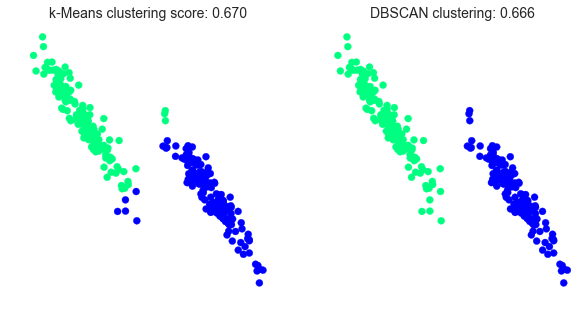

In [51]:
np.random.seed(172)
from sklearn.metrics import silhouette_score
X, y = make_blobs(n_samples=300, centers=2,)
transformation = [[0.4, -0.8], [-0.4, 0.4]]
X = np.dot(X, transformation)

km = KMeans(n_clusters=2)
prediction_kmeans = km.fit_predict(X)
score_kmeans = silhouette_score(X, km.labels_ ) 


db = DBSCAN(eps=0.67)
prediction_db = db.fit_predict(X)
score_db = silhouette_score(X, db.labels_ ) 

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title('k-Means clustering score: {:0.3f}'.format(score_kmeans))
ax1.scatter(X[:, 0], X[:, 1], c=prediction_kmeans, cmap='winter')
ax1.axis('off')

ax2.set_title('DBSCAN clustering: {:0.3f}'.format(score_db))
ax2.scatter(X[:, 0], X[:, 1], c=prediction_db, cmap='winter')
ax2.axis('off')
None

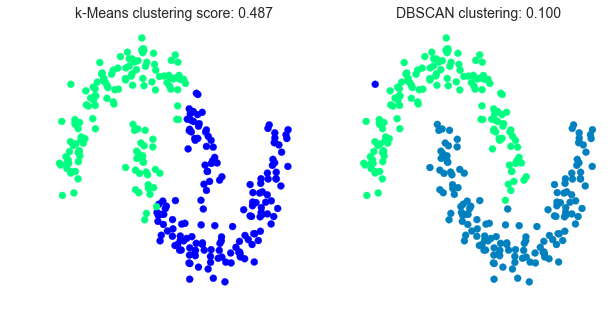

In [52]:
X, y = make_moons(n_samples=300, noise=0.1)

km = KMeans(n_clusters=2)
prediction_kmeans = km.fit_predict(X)
score_kmeans = silhouette_score(X, km.labels_ ) 

db = DBSCAN(eps=0.19)
prediction_db = db.fit_predict(X)
score_db = silhouette_score(X, db.labels_ ) 

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title('k-Means clustering score: {:0.3f}'.format(score_kmeans))
ax1.scatter(X[:, 0], X[:, 1], c=prediction_kmeans, cmap='winter')
ax1.axis('off')

ax2.set_title('DBSCAN clustering: {:0.3f}'.format(score_db))
ax2.scatter(X[:, 0], X[:, 1], c=prediction_db, cmap='winter')
ax2.axis('off')
None

# More Material

Read scikit-learns's user guide. It's detailed and describes pros and cons of many alogirthms and evaluation criteria.
Its also full of code examples.

http://scikit-learn.org/stable/user_guide.html

Read the book by Hastie (if you're a crazy maths person)

http://web.stanford.edu/~hastie/ElemStatLearn/

Read this book by James and Hastie (if you're a normal person)

http://www-bcf.usc.edu/~gareth/ISL/


A nice intro into Deep Learning and Neural Networks

http://cs231n.github.io

